In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cvxpy as cp
import time
from tqdm import tqdm

In [28]:
def solve_hetdp_cor(eps, k, beta, num_solver):
	n = len(eps)
	ones = np.ones(n)

	w = cp.Variable(n)
	objective2 = cp.Minimize(cp.power(cp.norm(w/eps,'inf'),2)*((np.log(k/beta))**2) + cp.power(cp.norm(w - (ones/n),1),2))
	constraints2 = [0 <= w, w@ones == 1]
	prob2 = cp.Problem(objective2, constraints2)
	result2 = prob2.solve(solver = num_solver)

	return w.value, np.sqrt(result2)

def solve_hetdp_cor_approx(eps, k, beta):
	EPS = eps.copy()
	indices = np.argsort(EPS)
	EPS_SORT = np.sort(EPS)
	r = []
	r.append(EPS_SORT[0])
	L1 = EPS_SORT[0]
	L2 = np.square(EPS_SORT[0])
	count = 1
	fac = ((np.log(k/beta))**2)/len(EPS_SORT)
	while count < len(EPS_SORT):
		rt = min(EPS_SORT[count],(L2 + fac)/L1)
		L1 = L1 + rt
		L2 = L2 + np.square(rt)
		r.append(rt)
		count += 1
		
	w_r = np.zeros(len(EPS_SORT))
	for i in range(len(r)):
		w_r[indices[i]] = r[i]/L1
	return w_r, 1

def solve_hetdp_uncor(eps, k, beta, num_solver):
	n = len(eps)
	ones = np.ones(n)

	w = cp.Variable(n)
	objective1 = cp.Minimize(cp.power(cp.norm(w/eps,'inf'),2)*((np.log(k/beta))**2) + cp.power(cp.norm(w - (ones/n),1),2))
	constraints1 = [0 <= w, w@ones == 1]
	prob1 = cp.Problem(objective1, constraints1)
	result1 = prob1.solve(solver = num_solver)

	w2 = cp.Variable(n)
	objective2 = cp.Minimize(cp.power(cp.norm(w2/eps,'inf'),2)*((np.log(k/beta))**2) + cp.power(cp.norm(w2,2),2)*np.log(k/beta))
	constraints2 = [0 <= w2, w2@ones == 1]
	prob2 = cp.Problem(objective2, constraints2)
	result2 = prob2.solve(solver = num_solver)

	if result1 < result2:
		return w.value, np.sqrt(result1)
	else:
		return w2.value, np.sqrt(result2)

def solve_hetdp_uncor_approx(eps, k, beta):
	## first try 
	n = len(eps)
	EPS = eps.copy()
	indices = np.argsort(EPS)
	EPS_SORT = np.sort(EPS)
	r = []
	r.append(EPS_SORT[0])
	L1 = EPS_SORT[0]
	L2 = np.square(EPS_SORT[0])
	count = 1
	fac = ((np.log(k/beta))**2)/n
	while count < len(EPS_SORT):
		rt = min(EPS_SORT[count],(L2 + fac)/L1)
		L1 = L1 + rt
		L2 = L2 + np.square(rt)
		r.append(rt)
		count += 1
	value = (n*L2)/(L1**2) - 1 + (np.log(k/beta)*np.log(k/beta))/(L1*L1)
	w_r = np.zeros(len(EPS_SORT))
	for i in range(len(r)):
		w_r[indices[i]] = r[i]/L1

	## second try
	r = []
	r.append(EPS_SORT[0])
	L1 = EPS_SORT[0]
	L2 = np.square(EPS_SORT[0])
	count = 1
	fac = np.log(k/beta)
	while count < len(EPS_SORT):
		rt = min(EPS_SORT[count],(L2 + fac)/L1)
		L1 = L1 + rt
		L2 = L2 + np.square(rt)
		r.append(rt)
		count += 1
	value2 = np.log(k/beta)*L2/(L1**2) + (np.log(k/beta)*np.log(k/beta))/(L1*L1)
	w_r2 = np.zeros(len(EPS_SORT))
	for i in range(len(r)):
		w_r2[indices[i]] = r[i]/L1

	#return w_r2, 'log'
	if value2 < value:
		return w_r2, 'log'
	else:
		return w_r, 'n'

In [29]:
def get_error(est,counts):
	return min(np.max(np.abs(est - counts)),1)
def get_error_vector(est,counts):
	## est is trials x k
	## counts is k
	return np.minimum(np.max(np.abs(est-counts),axis=1),1)
	

In [30]:
def gen_dataset(n,k, lamb=1):

	p = np.power(lamb,np.arange(k))
	p = p/np.sum(p)

	D = np.random.choice(k, size = n, p = p)
	DMatrix = np.zeros((k,n))
	for i in range(n):
		DMatrix[D[i],i] = 1
	
	counts = np.sum(DMatrix,axis=1)
	return DMatrix, counts

## Correlated Synthetic Dataset, k = 5

In [31]:
## Synthetic Dataset
np.random.seed(1)
beta = 0.05
n = 10000
k = 5


Data = np.zeros((k,n))
_, counts = gen_dataset(n,k,0.8)
ct = 0 
print(counts)
for i in range(len(counts)):
	Data[i,ct:ct+int(counts[i])] = 1
	ct += int(counts[i])
eps = np.zeros(n)
ct = 0 
for i in range(len(counts)):
	eps[ct:ct+int(counts[i])] = np.exp(-2*i+np.random.uniform(0,3*i,int(counts[i])))
	ct += int(counts[i])


trials = 5000
Dmatrix = Data
counts = counts/n

print('Counts is ',counts)

### hpfc ###
begin = time.time()
w_hpfc, result = solve_hetdp_cor(eps, k, beta, cp.ECOS)
L_hpfc = 2*np.max(w_hpfc/eps)
N_hpfc = np.random.laplace(0,L_hpfc,(k,trials))
end = time.time()
print('Done HPF-C in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = 2*infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,(k,trials))
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### hpfc-approx ###
begin = time.time()
w_hpfct, result = solve_hetdp_cor_approx(eps, k, beta)
L_hpfct = 2*np.max(w_hpfct/eps)
N_hpfct = np.random.laplace(0,L_hpfct,(k,trials))
end = time.time()
print('Done HPF-CT in ',end-begin,' seconds')

[3040. 2298. 1962. 1518. 1182.]
Counts is  [0.304  0.2298 0.1962 0.1518 0.1182]
Done HPF-C in  1.2269079685211182  seconds
Done HPF-A in  0.0016832351684570312  seconds
Done HPF-CT in  0.023718833923339844  seconds


In [32]:
errors_hpfc = get_error_vector(Dmatrix@w_hpfc + N_hpfc.transpose(),counts)
errors_hpfa = get_error_vector(Dmatrix@w_hpfa + N_hpfa.transpose(),counts)
errors_hpfct = get_error_vector(Dmatrix@w_hpfct + N_hpfct.transpose(),counts)

In [33]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfc), min(errors_hpfct))
max_range = max(max(errors_hpfa),max(errors_hpfc), max(errors_hpfct))
BINS = 10 ** np.linspace(np.log10(min_range), np.log10(max_range), 1000)

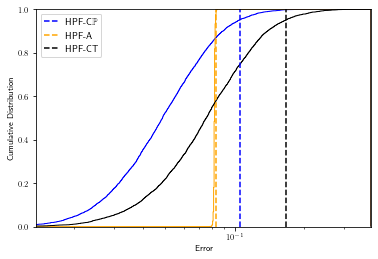

In [34]:
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

plt.xscale('log')

x1, bins, p1 =plt.hist(errors_hpfc, alpha = 1, bins = BINS, color='blue', histtype='step', cumulative=True, density=True)
x2, bins, p2 =plt.hist(errors_hpfa, alpha = 1, bins = BINS, color='orange', histtype='step', cumulative=True, density=True)
x3, bins, p3 =plt.hist(errors_hpfct, alpha = 1,  bins = BINS, color='black', histtype='step', cumulative=True, density=True)

plt.ylim(0,1)
plt.xlim(min_range*5, max_range)

plt.axvline(x = np.quantile(errors_hpfc,0.95), color = 'blue', linestyle = '--', label=r"HPF-C$\mathbb{P}$")
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPF-A')
plt.axvline(x = np.quantile(errors_hpfct,0.95), color = 'black', linestyle = '--', label='HPF-CT')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')
plt.legend(loc='upper left')
plt.savefig("ApdCorSyn1.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [35]:
print(np.quantile(errors_hpfc,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_hpfct,0.95))

0.10509338854214294 0.08281306736934593 0.16737309593013558


## Correlated Synthetic k = 20

In [36]:
## Synthetic Dataset
np.random.seed(1)
beta = 0.05
n = 10000
k = 20


Data = np.zeros((k,n))
_, counts = gen_dataset(n,k,0.8)
ct = 0 
print(counts)
for i in range(len(counts)):
	Data[i,ct:ct+int(counts[i])] = 1
	ct += int(counts[i])
eps = np.zeros(n)
ct = 0 
for i in range(len(counts)):
	eps[ct:ct+int(counts[i])] = np.exp(np.random.uniform(-0.3*i,0.3*i,int(counts[i])))
	ct += int(counts[i])


trials = 5000
Dmatrix = Data
counts = counts/n

print('Counts is ',counts)

### hpfc ###
begin = time.time()
w_hpfc, result = solve_hetdp_cor(eps, k, beta, cp.ECOS)
L_hpfc = 2*np.max(w_hpfc/eps)
N_hpfc = np.random.laplace(0,L_hpfc,(k,trials))
end = time.time()
print('Done HPF-C in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = 2*infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,(k,trials))
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')

### hpfc-approx ###
begin = time.time()
w_hpfct, result = solve_hetdp_cor_approx(eps, k, beta)
L_hpfct = 2*np.max(w_hpfct/eps)
N_hpfct = np.random.laplace(0,L_hpfct,(k,trials))
end = time.time()
print('Done HPF-CT in ',end-begin,' seconds')

[2029. 1632. 1253. 1117.  794.  683.  527.  410.  344.  276.  217.  179.
  121.   88.   88.   82.   56.   49.   27.   28.]
Counts is  [0.2029 0.1632 0.1253 0.1117 0.0794 0.0683 0.0527 0.041  0.0344 0.0276
 0.0217 0.0179 0.0121 0.0088 0.0088 0.0082 0.0056 0.0049 0.0027 0.0028]
Done HPF-C in  1.0530569553375244  seconds
Done HPF-A in  0.003937721252441406  seconds
Done HPF-CT in  0.024326086044311523  seconds


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [37]:
errors_hpfc = get_error_vector(Dmatrix@w_hpfc + N_hpfc.transpose(),counts)
errors_hpfa = get_error_vector(Dmatrix@w_hpfa + N_hpfa.transpose(),counts)
errors_prop = get_error_vector(Dmatrix@w_hpfct + N_hpfct.transpose(),counts)

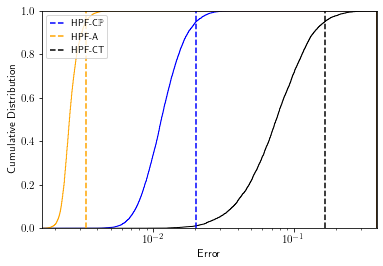

In [39]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfc), min(errors_hpfct))
max_range = max(max(errors_hpfa),max(errors_hpfc), max(errors_hpfct))
BINS = 10 ** np.linspace(np.log10(min_range), np.log10(max_range), 1000)

plt.xscale('log')

x1, bins, p1 =plt.hist(errors_hpfc, alpha = 1, bins = BINS, color='blue', histtype='step', cumulative=True, density=True)
x2, bins, p2 =plt.hist(errors_hpfa, alpha = 1, bins = BINS, color='orange', histtype='step', cumulative=True, density=True)
x3, bins, p3 =plt.hist(errors_hpfct, alpha = 1,  bins = BINS, color='black', histtype='step', cumulative=True, density=True)

plt.ylim(0,1)
plt.xlim(min_range, max_range)

plt.axvline(x = np.quantile(errors_hpfc,0.95), color = 'blue', linestyle = '--', label=r'HPF-C$\mathbb{P}$',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPF-A')
plt.axvline(x = np.quantile(errors_hpfct,0.95), color = 'black', linestyle = '--', label='HPF-CT')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("ApdCorSyn2.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [40]:
print(np.quantile(errors_hpfc,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_hpfct,0.95))

0.020236980582578393 0.003343892067475588 0.16737309593013558


### Uncorrelated Synthetic k=5

In [41]:
## Synthetic Dataset
np.random.seed(1)
beta = 0.05
n = 10000
k = 5
trials = int(n*np.log(n)*2)
eps = np.exp(np.random.uniform(-6,6,n))

Dmatrix , counts = gen_dataset(n,k,0.8)
print('Counts is ',counts)
counts = counts/np.sum(counts)

### hpfu ###
begin = time.time()
w_hpfu, result = solve_hetdp_uncor(eps, k, beta, cp.ECOS)
L_hpfu = 2*np.max(w_hpfu/eps)
N_hpfu = np.random.laplace(0,L_hpfu,(k,trials))
end = time.time()
print('Done HPF-U in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = 2*infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,(k,trials))
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### hpfu-approx ###
begin = time.time()
w_hpfut, result = solve_hetdp_uncor_approx(eps, k, beta)
L_hpfut = 2*np.max(w_hpfut/eps)
N_hpfut = np.random.laplace(0,L_hpfut,(k,trials))
end = time.time()
print('Done HPF-UT in ',end-begin,' seconds')

Counts is  [2907. 2365. 1889. 1625. 1214.]


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done HPF-U in  2.360786199569702  seconds
Done HPF-A in  0.03088688850402832  seconds
Done HPF-UT in  0.07567906379699707  seconds


In [42]:
errors_hpfu = np.zeros(trials)
errors_hpfa = np.zeros(trials)
errors_hpfut = np.zeros(trials)


for _ in tqdm(range(trials)):
	np.random.shuffle(w_hpfu)
	np.random.shuffle(w_hpfa)
	np.random.shuffle(w_hpfut)
	

	est_hpfu= Dmatrix@w_hpfu + N_hpfu[:,_]
	est_hpfa = Dmatrix@w_hpfa + N_hpfa[:,_]
	est_hpfut = Dmatrix@w_hpfut + N_hpfut[:,_]
	errors_hpfu[_]= get_error(est_hpfu,counts)
	errors_hpfa[_]= get_error(est_hpfa,counts)
	errors_hpfut[_]= get_error(est_hpfut,counts)

100%|██████████| 184206/184206 [01:43<00:00, 1775.25it/s]


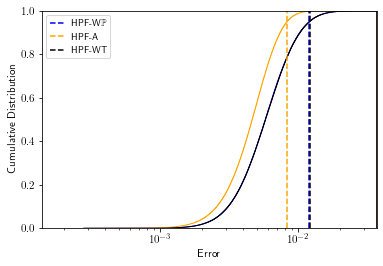

In [43]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfu), min(errors_hpfut))
max_range = max(max(errors_hpfa),max(errors_hpfu), max(errors_hpfut))
BINS = 10 ** np.linspace(np.log10(min_range), np.log10(max_range), 1000)
plt.xscale('log')

x1, bins, p1 =plt.hist(errors_hpfu, alpha = 1, bins = BINS, color='blue', histtype='step', cumulative=True, density=True)
x2, bins, p2 =plt.hist(errors_hpfa, alpha = 1, bins = BINS, color='orange', histtype='step', cumulative=True, density=True)
x3, bins, p3 =plt.hist(errors_hpfut, alpha = 1,  bins = BINS, color='black', histtype='step', cumulative=True, density=True)

plt.ylim(0,1)
plt.xlim(min_range/2, max_range)

plt.axvline(x = np.quantile(errors_hpfu,0.95), color = 'blue', linestyle = '--', label=r'HPF-W$\mathbb{P}$',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPF-A')
plt.axvline(x = np.quantile(errors_hpfut,0.95), color = 'black', linestyle = '--', label='HPF-WT')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("ApdUncorSyn1.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [33]:
print(np.quantile(errors_hpfu,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_hpfut,0.95))

0.012048279558507548 0.008309263743293827 0.01209675483642212


### Uncor Syn k=20

In [44]:
## Synthetic Dataset
np.random.seed(1)
beta = 0.05
n = 10000
k = 20
trials = int(n*np.log(n)*2)
eps = np.exp(np.random.uniform(-5,9,n))

Dmatrix , counts = gen_dataset(n,k,0.8)
print('Counts is ',counts)
counts = counts/np.sum(counts)

### hpfu ###
begin = time.time()
w_hpfu, result = solve_hetdp_uncor(eps, k, beta, cp.ECOS)
L_hpfu = 2*np.max(w_hpfu/eps)
N_hpfu = np.random.laplace(0,L_hpfu,(k,trials))
end = time.time()
print('Done HPF-U in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = 2*infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,(k,trials))
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### hpfu-approx ###
begin = time.time()
w_hpfut, result = solve_hetdp_uncor_approx(eps, k, beta)
L_hpfut = 2*np.max(w_hpfut/eps)
N_hpfut = np.random.laplace(0,L_hpfut,(k,trials))
end = time.time()
print('Done HPF-UT in ',end-begin,' seconds')

Counts is  [2004. 1561. 1265. 1051.  835.  676.  562.  437.  379.  264.  213.  200.
  143.  111.   75.   64.   56.   47.   26.   31.]


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done HPF-U in  2.6212968826293945  seconds
Done HPF-A in  0.1260240077972412  seconds
Done HPF-UT in  0.17151117324829102  seconds


In [45]:
errors_hpfu = np.zeros(trials)
errors_hpfa = np.zeros(trials)
errors_hpfut = np.zeros(trials)


for _ in tqdm(range(trials)):
	np.random.shuffle(w_hpfu)
	np.random.shuffle(w_hpfa)
	np.random.shuffle(w_hpfut)
	

	est_hpfu= Dmatrix@w_hpfu + N_hpfu[:,_]
	est_hpfa = Dmatrix@w_hpfa + N_hpfa[:,_]
	est_hpfut = Dmatrix@w_hpfut + N_hpfut[:,_]
	errors_hpfu[_]= get_error(est_hpfu,counts)
	errors_hpfa[_]= get_error(est_hpfa,counts)
	errors_hpfut[_]= get_error(est_hpfut,counts)

100%|██████████| 184206/184206 [01:52<00:00, 1634.50it/s]


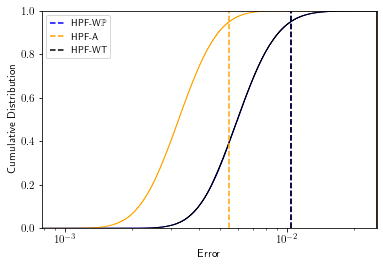

In [46]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfu), min(errors_hpfut))
max_range = max(max(errors_hpfa),max(errors_hpfu), max(errors_hpfut))
BINS = 10 ** np.linspace(np.log10(min_range), np.log10(max_range), 1000)
plt.xscale('log')

x1, bins, p1 =plt.hist(errors_hpfu, alpha = 1, bins = BINS, color='blue', histtype='step', cumulative=True, density=True)
x2, bins, p2 =plt.hist(errors_hpfa, alpha = 1, bins = BINS, color='orange', histtype='step', cumulative=True, density=True)
x3, bins, p3 =plt.hist(errors_hpfut, alpha = 1,  bins = BINS, color='black', histtype='step', cumulative=True, density=True)

plt.ylim(0,1)
plt.xlim(min_range, max_range)

plt.axvline(x = np.quantile(errors_hpfu,0.95), color = 'blue', linestyle = '--', label=r'HPF-W$\mathbb{P}$')
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPF-A')
plt.axvline(x = np.quantile(errors_hpfut,0.95), color = 'black', linestyle = '--', label='HPF-WT')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("ApdUncorSyn2.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [53]:
print(np.quantile(errors_hpfu,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_hpfut,0.95))

0.01040125536313365 0.005488739621072769 0.010422301455965729


In [58]:
## Synthetic Dataset
np.random.seed(1)
beta = 0.05
n = 10000
k = 5
trials = int(n*np.log(n)*2)
eps = np.exp(np.random.uniform(-2,2,n))

Dmatrix , counts = gen_dataset(n,k,0.8)
print('Counts is ',counts)
counts = counts/np.sum(counts)

### hpfu ###
begin = time.time()
w_hpfu, result = solve_hetdp_uncor(eps, k, beta, cp.ECOS)
L_hpfu = 2*np.max(w_hpfu/eps)
N_hpfu = np.random.laplace(0,L_hpfu,(k,trials))
end = time.time()
print('Done HPF-U in ',end-begin,' seconds')


### hpfa ###
begin = time.time()
w_hpfa = 1-np.exp(-eps)
w_hpfa = w_hpfa/np.sum(w_hpfa)
infty_norm = np.max(w_hpfa/eps)
L_hpfa = 2*infty_norm
N_hpfa = np.random.laplace(0,L_hpfa,(k,trials))
end = time.time()
print('Done HPF-A in ',end-begin,' seconds')


### hpfu-approx ###
begin = time.time()
w_hpfut, result = solve_hetdp_uncor_approx(eps, k, beta)
L_hpfut = 2*np.max(w_hpfut/eps)
N_hpfut = np.random.laplace(0,L_hpfut,(k,trials))
end = time.time()
print('Done HPF-UT in ',end-begin,' seconds')

Counts is  [2907. 2365. 1889. 1625. 1214.]


/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1296: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Done HPF-U in  2.554561138153076  seconds
Done HPF-A in  0.027959823608398438  seconds
Done HPF-UT in  0.07854890823364258  seconds


In [59]:
errors_hpfu = np.zeros(trials)
errors_hpfa = np.zeros(trials)
errors_hpfut = np.zeros(trials)


for _ in tqdm(range(trials)):
	np.random.shuffle(w_hpfu)
	np.random.shuffle(w_hpfa)
	np.random.shuffle(w_hpfut)
	

	est_hpfu= Dmatrix@w_hpfu + N_hpfu[:,_]
	est_hpfa = Dmatrix@w_hpfa + N_hpfa[:,_]
	est_hpfut = Dmatrix@w_hpfut + N_hpfut[:,_]
	errors_hpfu[_]= get_error(est_hpfu,counts)
	errors_hpfa[_]= get_error(est_hpfa,counts)
	errors_hpfut[_]= get_error(est_hpfut,counts)

100%|██████████| 184206/184206 [02:08<00:00, 1436.78it/s]


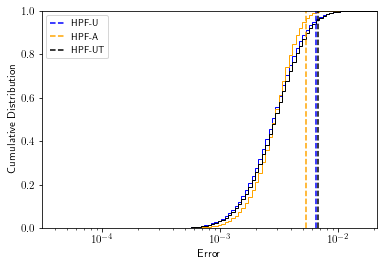

In [60]:
params = {'text.usetex' : True,
          'font.size' : 11,
		  'legend.fontsize': 9,
          'legend.handlelength': 1.5,
          }
plt.rcParams.update(params) 

min_range = min(min(errors_hpfa),min(errors_hpfu), min(errors_hpfut))
max_range = max(max(errors_hpfa),max(errors_hpfu), max(errors_hpfut))
BINS = 10 ** np.linspace(np.log10(min_range), np.log10(max_range), 100)
plt.xscale('log')

x1, bins, p1 =plt.hist(errors_hpfu, alpha = 1, bins = BINS, color='blue', histtype='step', cumulative=True, density=True)
x2, bins, p2 =plt.hist(errors_hpfa, alpha = 1, bins = BINS, color='orange', histtype='step', cumulative=True, density=True)
x3, bins, p3 =plt.hist(errors_hpfut, alpha = 1,  bins = BINS, color='black', histtype='step', cumulative=True, density=True)

plt.ylim(0,1)
plt.xlim(min_range, max_range)

plt.axvline(x = np.quantile(errors_hpfu,0.95), color = 'blue', linestyle = '--', label='HPF-U',)
plt.axvline(x = np.quantile(errors_hpfa,0.95), color = 'orange', linestyle = '--', label='HPF-A')
plt.axvline(x = np.quantile(errors_hpfut,0.95), color = 'black', linestyle = '--', label='HPF-UT')


plt.xlabel('Error')
plt.ylabel('Cumulative Distribution')

plt.legend(loc='upper left')
plt.savefig("ApdUncorSyn1-LowVar.pdf", 
            dpi=1000, 
            bbox_inches='tight', 
            )
plt.show()

In [61]:
print(np.quantile(errors_hpfu,0.95), np.quantile(errors_hpfa,0.95), np.quantile(errors_hpfut,0.95))

0.006460290840736821 0.005315946327339831 0.006705377394489669
